In [23]:
import sys
print(sys.executable)
print(sys.version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


c:\Users\Tishie\Desktop\Ambulance-Allocation-Research\venv\Scripts\python.exe
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [24]:
df = pd.read_csv("../data/district_flood_data.csv")

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

df.head(), df.info(), df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   district               80 non-null     object
 1   year                   80 non-null     int64 
 2   flood_event_count      80 non-null     int64 
 3   affected_population    80 non-null     int64 
 4   severity_index         80 non-null     int64 
 5   avg_rainfall_mm        80 non-null     int64 
 6   road_disruption_level  80 non-null     int64 
 7   ambulances_needed      80 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 5.1+ KB


(  district  year  flood_event_count  affected_population  severity_index  \
 0    Kandy  2010                  2                  300               3   
 1    Kandy  2011                  2                  340               3   
 2    Kandy  2012                  2                  380               3   
 3    Kandy  2013                  1                  280               2   
 4    Kandy  2014                  2                  350               3   
 
    avg_rainfall_mm  road_disruption_level  ambulances_needed  
 0              150                      3                  5  
 1              160                      3                  5  
 2              170                      3                  5  
 3              140                      2                  3  
 4              160                      3                  5  ,
 None,
 district                 0
 year                     0
 flood_event_count        0
 affected_population      0
 severity_index           0
 avg

In [25]:
df["pop_norm"] = (df["affected_population"] - df["affected_population"].min()) / (df["affected_population"].max() - df["affected_population"].min())
df["rain_norm"] = (df["avg_rainfall_mm"] - df["avg_rainfall_mm"].min()) / (df["avg_rainfall_mm"].max() - df["avg_rainfall_mm"].min())
df["road_norm"] = (df["road_disruption_level"] - df["road_disruption_level"].min()) / (df["road_disruption_level"].max() - df["road_disruption_level"].min())

df["severity_score"] = (
    0.4*df["rain_norm"] +
    0.3*df["pop_norm"] +
    0.3*df["road_norm"]
)

threshold = df["severity_score"].median()

df["scenario_id"] = df["severity_score"].apply(
    lambda x: "FLOOD_S2" if x >= threshold else "FLOOD_S1"
)

df[["district","year","severity_score","scenario_id"]].head(30)


,district,year,severity_score,scenario_id
0,Kandy,2010,0.119820,FLOOD_S1
1,Kandy,2011,0.139641,FLOOD_S1
2,Kandy,2012,0.159461,FLOOD_S1
3,Kandy,2013,0.001215,FLOOD_S1
4,Kandy,2014,0.140248,FLOOD_S1
5,Kandy,2015,0.161891,FLOOD_S1
6,Kandy,2016,0.321959,FLOOD_S1
7,Kandy,2017,0.342387,FLOOD_S1
8,Kandy,2018,0.181104,FLOOD_S1
9,Kandy,2019,0.360993,FLOOD_S1


In [26]:
features = [
    "flood_event_count",
    "affected_population",
    "severity_index",
    "avg_rainfall_mm",
    "road_disruption_level"
]

df_s1 = df[df["scenario_id"] == "FLOOD_S1"]
df_s2 = df[df["scenario_id"] == "FLOOD_S2"]

X_s1 = df_s1[features]
y_s1 = df_s1["ambulances_needed"]

X_s2 = df_s2[features]
y_s2 = df_s2["ambulances_needed"]



In [27]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X_s1, y_s1, test_size=0.2, random_state=42
)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X_s2, y_s2, test_size=0.2, random_state=42
)

model_s1 = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
model_s2 = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)

model_s1.fit(X1_train, y1_train)
model_s2.fit(X2_train, y2_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

In [28]:
lr_s1 = LinearRegression()
lr_s2 = LinearRegression()

lr_s1.fit(X1_train, y1_train)
lr_s2.fit(X2_train, y2_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [29]:
import numpy as np
import pandas as pd


In [30]:
rf_pred_s1 = model_s1.predict(X1_test)
rf_pred_s2 = model_s2.predict(X2_test)

lr_pred_s1 = lr_s1.predict(X1_test)
lr_pred_s2 = lr_s2.predict(X2_test)

print("\n MODEL PERFORMANCE COMPARISON")
print("--------------------------------")
print("S1 RF  :", mean_absolute_error(y1_test, rf_pred_s1))
print("S1 LR  :", mean_absolute_error(y1_test, lr_pred_s1))
print("S2 RF  :", mean_absolute_error(y2_test, rf_pred_s2))
print("S2 LR  :", mean_absolute_error(y2_test, lr_pred_s2))



 MODEL PERFORMANCE COMPARISON
--------------------------------
S1 RF  : 0.38031249999999994
S1 LR  : 0.3010770299559389
S2 RF  : 0.5284732142857147
S2 LR  : 0.8319788456784187


In [31]:
features = [
    "flood_event_count",
    "affected_population",
    "severity_index",
    "avg_rainfall_mm",
    "road_disruption_level"
]

# S1 importance
rf_importance_s1 = pd.Series(
    model_s1.feature_importances_,
    index=features
).sort_values(ascending=False)

# S2 importance
rf_importance_s2 = pd.Series(
    model_s2.feature_importances_,
    index=features
).sort_values(ascending=False)

print("\nRandom Forest Feature Importance – FLOOD_S1\n")
print(rf_importance_s1)

print("\nRandom Forest Feature Importance – FLOOD_S2\n")
print(rf_importance_s2)



Random Forest Feature Importance – FLOOD_S1

affected_population      0.669445
avg_rainfall_mm          0.283028
severity_index           0.024441
road_disruption_level    0.015699
flood_event_count        0.007387
dtype: float64

Random Forest Feature Importance – FLOOD_S2

avg_rainfall_mm          0.521154
affected_population      0.296733
flood_event_count        0.091732
road_disruption_level    0.047931
severity_index           0.042449
dtype: float64


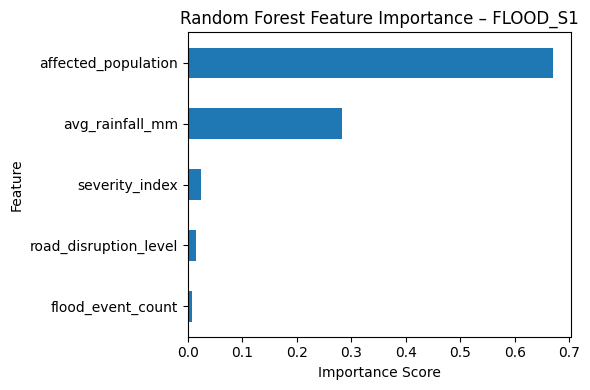

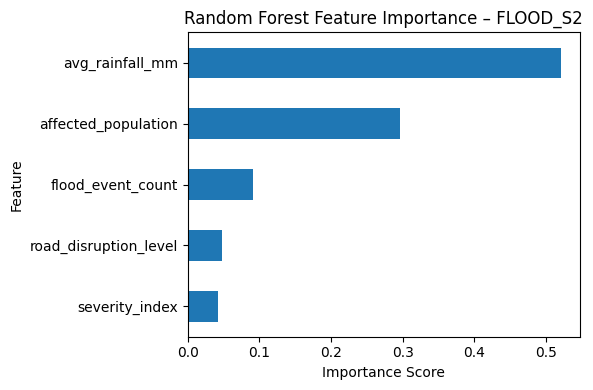

In [32]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, title):
    importance = pd.Series(
        model.feature_importances_,
        index=features
    ).sort_values()

    plt.figure(figsize=(6,4))
    importance.plot(kind="barh")
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_feature_importance(model_s1, "Random Forest Feature Importance – FLOOD_S1")
plot_feature_importance(model_s2, "Random Forest Feature Importance – FLOOD_S2")


In [33]:
lr_importance_s1 = pd.Series(
    lr_s1.coef_,
    index=features
).sort_values(key=abs, ascending=False)

lr_importance_s2 = pd.Series(
    lr_s2.coef_,
    index=features
).sort_values(key=abs, ascending=False)

print("\nLinear Regression Coefficient Importance – FLOOD_S1\n")
print(lr_importance_s1)

print("\nLinear Regression Coefficient Importance – FLOOD_S2\n")
print(lr_importance_s2)



Linear Regression Coefficient Importance – FLOOD_S1

severity_index           0.371212
road_disruption_level    0.371212
flood_event_count       -0.074991
avg_rainfall_mm          0.010278
affected_population      0.008998
dtype: float64

Linear Regression Coefficient Importance – FLOOD_S2

flood_event_count        1.110234
severity_index           0.460413
road_disruption_level    0.460413
avg_rainfall_mm          0.047823
affected_population     -0.000062
dtype: float64


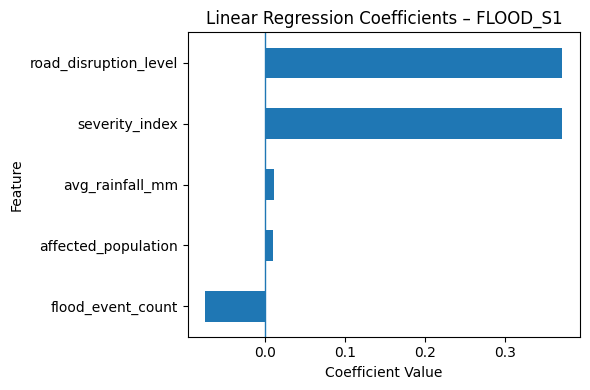

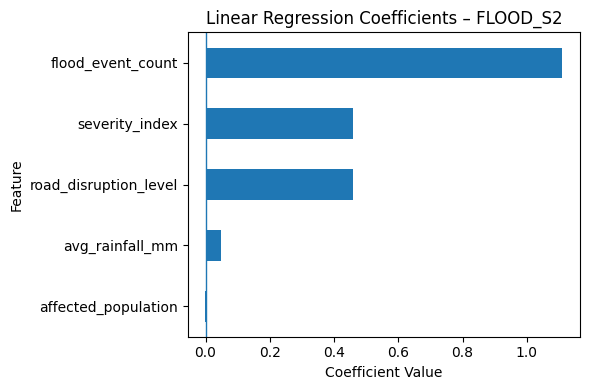

In [34]:
def plot_lr_coefficients(model, title):
    coeffs = pd.Series(model.coef_, index=features).sort_values()

    plt.figure(figsize=(6,4))
    coeffs.plot(kind="barh")
    plt.title(title)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.axvline(0, linewidth=1)
    plt.tight_layout()
    plt.show()

plot_lr_coefficients(lr_s1, "Linear Regression Coefficients – FLOOD_S1")
plot_lr_coefficients(lr_s2, "Linear Regression Coefficients – FLOOD_S2")


In [35]:
def predict_scenario(flood_event_count,
                     affected_population,
                     avg_rainfall_mm,
                     road_disruption_level):

    rain_norm = avg_rainfall_mm / 300
    pop_norm = affected_population / 5000
    road_norm = road_disruption_level / 5

    severity_score = (0.4 * rain_norm) + (0.3 * pop_norm) + (0.3 * road_norm)

    scenario = "FLOOD_S2" if severity_score >= 0.5 else "FLOOD_S1"

    return scenario, severity_score



In [36]:
def predict_ambulances(
    flood_event_count,
    affected_population,
    severity_index,
    avg_rainfall_mm,
    road_disruption_level
):

    scenario, severity_score = predict_scenario(
        flood_event_count,
        affected_population,
        avg_rainfall_mm,
        road_disruption_level
    )

    row = pd.DataFrame([{
        "flood_event_count": flood_event_count,
        "affected_population": affected_population,
        "severity_index": severity_index,
        "avg_rainfall_mm": avg_rainfall_mm,
        "road_disruption_level": road_disruption_level
    }])

    if scenario == "FLOOD_S1":
        pred = model_s1.predict(row)[0]
    else:
        pred = model_s2.predict(row)[0]

    pred = int(np.ceil(pred))

    return scenario, round(severity_score, 3), pred


In [37]:
predict_ambulances(
    flood_event_count=3,
    affected_population=1400,
    severity_index=4,
    avg_rainfall_mm=230,
    road_disruption_level=3
)


('FLOOD_S2', 0.571, 12)

In [38]:
districts = df["district"].unique()

results = []

for d in districts:

    # conservative mild flood case
    s1 = predict_ambulances(
        flood_event_count = 1,
        affected_population = int(df[df["district"]==d]["affected_population"].mean()*0.4),
        severity_index = 2,
        avg_rainfall_mm = int(df[df["district"]==d]["avg_rainfall_mm"].mean()*0.7),
        road_disruption_level = 2
    )

    # severe flood case
    s2 = predict_ambulances(
        flood_event_count = 4,
        affected_population = int(df[df["district"]==d]["affected_population"].mean()*1.2),
        severity_index = 5,
        avg_rainfall_mm = int(df[df["district"]==d]["avg_rainfall_mm"].mean()*1.1),
        road_disruption_level = 5
    )

    results.append([
        d,
        s1[0], s1[2],      # scenario label + ambulances
        s2[0], s2[2]       # scenario label + ambulances
    ])

scenario_compare = pd.DataFrame(
    results,
    columns=["district", "scenario_S1", "ambulances_S1", "scenario_S2", "ambulances_S2"]
)

scenario_compare


,district,scenario_S1,ambulances_S1,scenario_S2,ambulances_S2
0,Kandy,FLOOD_S1,4,FLOOD_S2,11
1,Nuwara Eliya,FLOOD_S1,5,FLOOD_S2,13
2,Ratnapura,FLOOD_S1,6,FLOOD_S2,17
3,Gampaha,FLOOD_S1,5,FLOOD_S2,14
4,Galle,FLOOD_S1,5,FLOOD_S2,13


In [39]:
scenario_compare["increase"] = scenario_compare["ambulances_S2"] - scenario_compare["ambulances_S1"]
scenario_compare


,district,scenario_S1,ambulances_S1,scenario_S2,ambulances_S2,increase
0,Kandy,FLOOD_S1,4,FLOOD_S2,11,7
1,Nuwara Eliya,FLOOD_S1,5,FLOOD_S2,13,8
2,Ratnapura,FLOOD_S1,6,FLOOD_S2,17,11
3,Gampaha,FLOOD_S1,5,FLOOD_S2,14,9
4,Galle,FLOOD_S1,5,FLOOD_S2,13,8


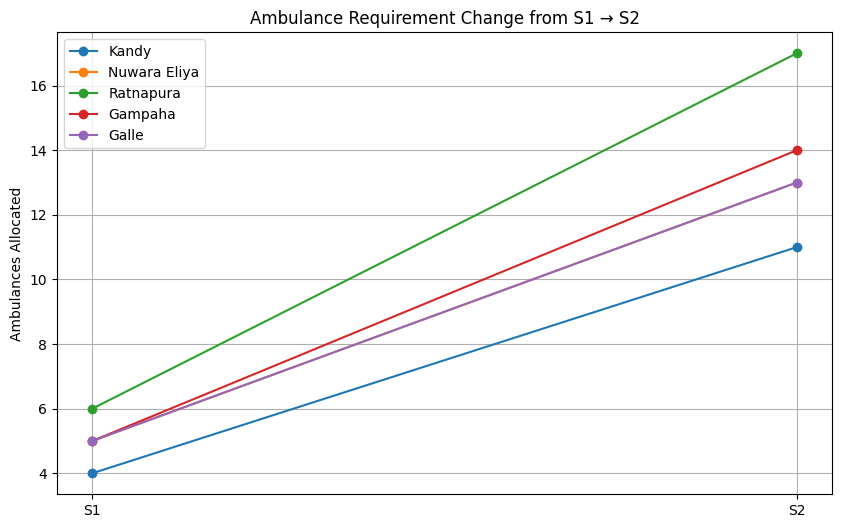

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for i, row in scenario_compare.iterrows():
    plt.plot(
        ["S1","S2"],
        [row["ambulances_S1"], row["ambulances_S2"]],
        marker="o",
        label=row["district"]
    )

plt.ylabel("Ambulances Allocated")
plt.title("Ambulance Requirement Change from S1 → S2")
plt.grid(True)
plt.legend()
plt.show()


In [47]:
def classify_scenario_from_gauges(gauge_readings):

    gauge_status = []

    for g in gauge_readings:

        warning_level = g["minor"] * 0.9   # 10% buffer below minor

        if g["water"] >= g["major"]:
            gauge_status.append(("major", g["name"]))

        elif g["water"] >= g["minor"]:
            gauge_status.append(("minor", g["name"]))

        elif g["water"] >= warning_level:
            gauge_status.append(("warning", g["name"]))

        else:
            gauge_status.append(("normal", g["name"]))

    if any(s[0] == "major" for s in gauge_status):
        return "FLOOD_S2", gauge_status

    if any(s[0] == "minor" for s in gauge_status):
        return "FLOOD_S1", gauge_status

    if any(s[0] == "warning" for s in gauge_status):
        return "PRE_WARNING", gauge_status

    return "NO_FLOOD", gauge_status


In [42]:
def estimate_variables_from_inputs(df, scenario, avg_rainfall_mm):

    pop_min = df["affected_population"].min()
    pop_max = df["affected_population"].max()

    rain_norm = (avg_rainfall_mm - df["avg_rainfall_mm"].min()) / \
                (df["avg_rainfall_mm"].max() - df["avg_rainfall_mm"].min())

    rain_norm = max(0, min(rain_norm, 1))

    if scenario == "FLOOD_S2":
        affected_population = pop_min + rain_norm * (pop_max - pop_min)
        road_disruption_level = 5
        severity_index = 5

    elif scenario == "FLOOD_S1":
        affected_population = pop_min + 0.5 * rain_norm * (pop_max - pop_min)
        road_disruption_level = 3
        severity_index = 3

    else:
        affected_population = pop_min
        road_disruption_level = 1
        severity_index = 1

    return int(affected_population), int(road_disruption_level), int(severity_index)


In [48]:
def predict_from_multiple_gauges(district, gauge_readings):

    results = []
    total_ambulances = 0

    for g in gauge_readings:

        # 1) scenario from gauge status
        scenario, _ = classify_scenario_from_gauges([g])

        # 2) estimate hidden ML variables from rainfall + scenario
        affected_population, road, severity = estimate_variables_from_inputs(
            df=df,
            scenario=scenario,
            avg_rainfall_mm=g["rain"]
        )

        # 3) base ML model input
        row = pd.DataFrame([{
            "flood_event_count": 2,
            "affected_population": affected_population,
            "severity_index": severity,
            "avg_rainfall_mm": g["rain"],
            "road_disruption_level": road
        }])

        # 4) choose model (warning uses S1 model)
        if scenario in ["FLOOD_S1", "PRE_WARNING"]:
            base_pred = model_s1.predict(row)[0]
        elif scenario == "FLOOD_S2":
            base_pred = model_s2.predict(row)[0]
        else:
            base_pred = 0

        # 5) continuous scaling with gauge height
        if g["major"] > 0:
            risk_factor = g["water"] / g["major"]
        else:
            risk_factor = 1

        # clamp reasonable range
        risk_factor = max(0.7, min(risk_factor, 1.6))

        adjusted_pred = base_pred * risk_factor

        # warning level = fewer ambulances than S1
        if scenario == "PRE_WARNING":
            adjusted_pred *= 0.6

        ambulances = int(np.ceil(adjusted_pred))
        total_ambulances += ambulances

        results.append({
            "district": district,
            "gauge": g["name"],
            "rain_mm": g["rain"],
            "scenario": scenario,
            "risk_factor": round(risk_factor, 2),
            "affected_population_est": int(affected_population),
            "predicted_ambulances": ambulances
        })

    return {
        "per_gauge_results": results,
        "total_ambulances": total_ambulances
    }


In [50]:
predict_from_multiple_gauges(
    "Kandy",
    [
        {"name":"Peradeniya", "water": 6.2, "minor": 4.5, "major": 6.0, "rain": 280},
        {"name":"Nawalapitiya", "water": 3.9, "minor": 4.0, "major": 5.5, "rain": 190}
    ]
)



{'per_gauge_results': [{'district': 'Kandy',
   'gauge': 'Peradeniya',
   'rain_mm': 280,
   'scenario': 'FLOOD_S2',
   'risk_factor': 1.03,
   'affected_population_est': 3266,
   'predicted_ambulances': 15},
  {'district': 'Kandy',
   'gauge': 'Nawalapitiya',
   'rain_mm': 190,
   'scenario': 'PRE_WARNING',
   'risk_factor': 0.71,
   'affected_population_est': 260,
   'predicted_ambulances': 2}],
 'total_ambulances': 17}

In [45]:
import joblib

joblib.dump(model_s1, "../models/ambulance_model_s1.pkl")
joblib.dump(model_s2, "../models/ambulance_model_s2.pkl")

print("Models saved successfully.")


Models saved successfully.
